# 모델링
LightGBM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

from scipy.spatial import distance
from math import log2
from math import sqrt
from sklearn.cluster import AgglomerativeClustering

!pip install bayesian-optimization

from sklearn.model_selection import KFold,StratifiedKFold   # K-fold CV 
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings(action = 'ignore')

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import RobustScaler

In [ ]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


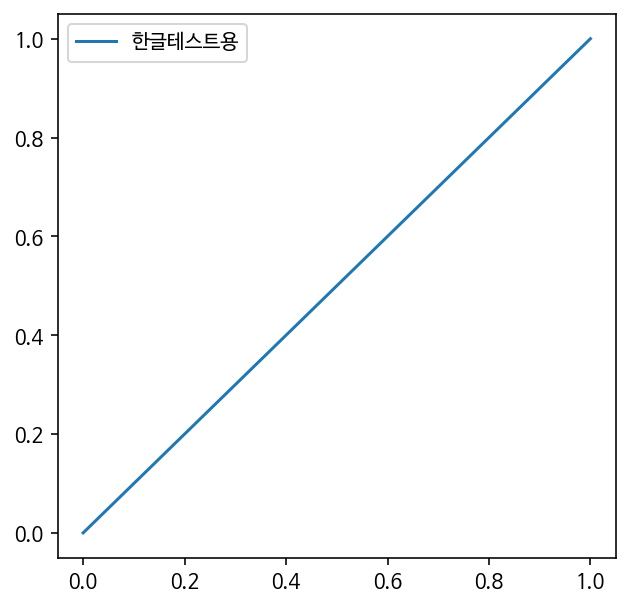

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/빅청캠/df_boosting.csv')
df.head()

,도시,공사,modified공종명,설계수량,공구별면적,주거면적,주거면적(%),공구별세대수,기간(월),이상치,hdb_clusters,hdb_mean,hdb_std,도-단cluster,공-단cluster,도공-단cluster,도-단비cluster,공-단비cluster,도공-단비cluster,도-수비cluster,공-수비cluster,도공-수비cluster,도-단clustermean,도-단clusterstd,공-단clustermean,공-단clusterstd,도공-단clustermean,도공-단clusterstd,도-단비clustermean,도-단비clusterstd,공-단비clustermean,공-단비clusterstd,도공-단비clustermean,도공-단비clusterstd,도-수비clustermean,도-수비clusterstd,공-수비clustermean,공-수비clusterstd,도공-수비clustermean,도공-수비clusterstd,도급단가합계
0,광교1,구조물공사,강관파일기초,7337.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,254,383301.857143,485940.558325,17,6,9,2,22,74,22,3,80,1.936300e+06,1.235332e+07,318080.400000,608002.829725,586871.333333,705899.572921,905478.762774,2.400655e+06,318080.400000,608002.829725,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413,1399421.0
1,광교1,구조물공사,되메우기및다짐,8973.0,1067184.0,604873.6,56.67941,9177.0,43.0,0,292,9276.842105,10462.150381,407,372,500,444,543,631,479,607,303,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8410.142857,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,1395.0
2,광교1,구조물공사,뒷채움부설및다짐,1558.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,1019,10549.523810,14778.036032,520,415,253,625,416,423,595,439,503,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4952.800000,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,2878.0
3,광교1,구조물공사,보강토옹벽,402.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,260,163376.000000,103302.643877,17,678,9,2,369,74,22,3,80,1.936300e+06,1.235332e+07,236422.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,236422.000000,NaN,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413,236422.0
4,광교1,구조물공사,식생옹벽블럭,341.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,265,30559.428571,47851.742577,17,672,9,2,311,338,504,3,204,1.936300e+06,1.235332e+07,124771.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,124771.000000,NaN,124771.000000,NaN,1.247710e+05,NaN,124222.157895,318363.549917,124771.000000,NaN,124771.0


In [ ]:
df.columns

Index(['도시', '공사', 'modified공종명', '설계수량', '공구별면적', '주거면적', '주거면적(%)', '공구별세대수',
       '기간(월)', '이상치', 'hdb_clusters', 'hdb_mean', 'hdb_std', '도-단cluster',
       '공-단cluster', '도공-단cluster', '도-단비cluster', '공-단비cluster',
       '도공-단비cluster', '도-수비cluster', '공-수비cluster', '도공-수비cluster',
       '도-단clustermean', '도-단clusterstd', '공-단clustermean', '공-단clusterstd',
       '도공-단clustermean', '도공-단clusterstd', '도-단비clustermean',
       '도-단비clusterstd', '공-단비clustermean', '공-단비clusterstd',
       '도공-단비clustermean', '도공-단비clusterstd', '도-수비clustermean',
       '도-수비clusterstd', '공-수비clustermean', '공-수비clusterstd',
       '도공-수비clustermean', '도공-수비clusterstd', '도급단가합계'],
      dtype='object')

In [ ]:
df = df[df['도급단가합계']>0]
df = df.reset_index(drop=True)
df.head()

,도시,공사,modified공종명,설계수량,공구별면적,주거면적,주거면적(%),공구별세대수,기간(월),이상치,hdb_clusters,hdb_mean,hdb_std,도-단cluster,공-단cluster,도공-단cluster,도-단비cluster,공-단비cluster,도공-단비cluster,도-수비cluster,공-수비cluster,도공-수비cluster,도-단clustermean,도-단clusterstd,공-단clustermean,공-단clusterstd,도공-단clustermean,도공-단clusterstd,도-단비clustermean,도-단비clusterstd,공-단비clustermean,공-단비clusterstd,도공-단비clustermean,도공-단비clusterstd,도-수비clustermean,도-수비clusterstd,공-수비clustermean,공-수비clusterstd,도공-수비clustermean,도공-수비clusterstd,도급단가합계
0,광교1,구조물공사,강관파일기초,7337.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,254,383301.857143,485940.558325,17,6,9,2,22,74,22,3,80,1.936300e+06,1.235332e+07,318080.400000,608002.829725,586871.333333,705899.572921,905478.762774,2.400655e+06,318080.400000,608002.829725,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413,1399421.0
1,광교1,구조물공사,되메우기및다짐,8973.0,1067184.0,604873.6,56.67941,9177.0,43.0,0,292,9276.842105,10462.150381,407,372,500,444,543,631,479,607,303,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8410.142857,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,1395.0
2,광교1,구조물공사,뒷채움부설및다짐,1558.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,1019,10549.523810,14778.036032,520,415,253,625,416,423,595,439,503,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4952.800000,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,2878.0
3,광교1,구조물공사,보강토옹벽,402.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,260,163376.000000,103302.643877,17,678,9,2,369,74,22,3,80,1.936300e+06,1.235332e+07,236422.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,236422.000000,NaN,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413,236422.0
4,광교1,구조물공사,식생옹벽블럭,341.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,265,30559.428571,47851.742577,17,672,9,2,311,338,504,3,204,1.936300e+06,1.235332e+07,124771.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,124771.000000,NaN,124771.000000,NaN,1.247710e+05,NaN,124222.157895,318363.549917,124771.000000,NaN,124771.0


In [ ]:
# train, test 나누기

train_df = df[df['도시'] != '동탄5']
test_df = df[df['도시'] == '동탄5']

In [ ]:
X_train=train_df.drop('도급단가합계',axis=1)
y_train=train_df['도급단가합계']
y_train = np.log1p(y_train)


X_test=test_df.drop('도급단가합계',axis=1)
y_test=test_df['도급단가합계']

#공구명 삭제
X_train.drop('도시',axis=1,inplace=True)
X_test.drop('도시',axis=1,inplace=True)

# X_train=train_df.drop('도급합계금액',axis=1)
# y_train=train_df['도급합계금액']
# X_test=test_df.drop('도급합계금액',axis=1)
# y_test=test_df['도급합계금액']

# #공구명 삭제
# X_train.drop('도시',axis=1,inplace=True)
# X_test.drop('도시',axis=1,inplace=True)

In [ ]:
cat_features = ['공사', 'modified공종명','hdb_clusters', '도-단cluster', '공-단cluster', '도공-단cluster','도-단비cluster', '공-단비cluster', '도공-단비cluster', '도-수비cluster','공-수비cluster', '도공-수비cluster']

In [ ]:
for col in cat_features:
  X_train[col] = X_train[col].astype('category')
  X_test[col] = X_test[col].astype('category')

In [ ]:
def lgb_cv(learning_rate,num_iterations,min_data_in_leaf, n_estimators,max_depth, subsample, colsample_bytree, reg_alpha,reg_lambda, x_data=None, y_data=None, n_splits=5, output='model'):
    score = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=201)
    models = []
    for train_index, valid_index in skf.split(x_data,x_data['hdb_clusters']):
       #print(train_index)
       x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
       x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]
        
       model = lgb.LGBMRegressor(
        
           learning_rate = learning_rate,
           num_iterations = int(num_iterations),
           min_data_in_leaf = int(min_data_in_leaf),  
           n_estimators = int(n_estimators),
           max_depth = int(max_depth), 
           subsample = np.clip(subsample, 0, 1), 
           colsample_bytree = np.clip(colsample_bytree, 0, 1), 
           reg_alpha = reg_alpha, 
           reg_lambda = reg_lambda,
           )
       
       model.fit(x_train, y_train)
       models.append(model)
        
       pred = model.predict(x_valid)
       true = y_valid
       mse =  mean_squared_error(true,pred)*(-1)
       mae = mean_absolute_error(true, pred)*(-1)
       R2 = r2_score(true, pred)
       #msle=mean_squared_log_error(true, pred)*(-1)
       score += mse/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [ ]:
# func_fixed = partial(lgb_cv, x_data=X_train, y_data=y_train, n_splits=5, output='score') 

# lgbBO = BayesianOptimization(
#     func_fixed, 
#     {
#         'learning_rate': (0.001, 0.01),
#         'num_iterations':(1500,2200),
#         'min_data_in_leaf':(2,4),
#         'n_estimators': (28,32), ##16,32
#         'max_depth':(28,32),
#         'subsample': (0.01, 1),
#         'colsample_bytree': (0.01, 1),
#         'reg_alpha': (0.01, 100), 
#         'reg_lambda': (0.01, 100),
#     }, 
#     random_state=4321
# )
# lgbBO.maximize(init_points=20, n_iter=5) #30

서치 고찰
- 학습률을 낮추고 estimator와 iteration을 많이 올리면 좀더 일반화되고 성능이 좋은 모델을 구현할 수 있음.
- 그 후, iteration을 계속 올리다가 오버피팅이 되는 부분을 찾으면 거기서 멈추면 됨.

In [ ]:
#params = lgbBO.max['params']
params = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4.0, 'min_data_in_leaf': 2.0, 'n_estimators': 8, 'num_iterations': 1250.3490939784444, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.01}
models = lgb_cv(   
    params['learning_rate'],
    params['num_iterations'],
    params['min_data_in_leaf'], 
    params['n_estimators'],
    params['max_depth'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=X_train, y_data=y_train, n_splits=5, output='model')

In [ ]:
preds = []
for model in models:
    pred = model.predict(X_train)
    preds.append(pred)

pred = np.mean(preds, axis=0)

In [ ]:
#mean_absolute_error(y_train,pred)
mean_squared_log_error(np.expm1(y_train), np.expm1(pred))**0.5

0.7081018035464247

In [ ]:
#r2_score(y_train, pred)
r2_score(np.expm1(y_train), np.expm1(pred))

0.7842454460665929

In [ ]:
preds = []
for model in models:
    pred = model.predict(X_test)
    preds.append(pred)

pred = np.mean(preds, axis=0)

In [ ]:
#mean_absolute_error(y_tset,pred)
mean_squared_log_error(y_test, np.expm1(pred))**0.5

1.1627493968190732

In [ ]:
#r2_score(y_test,pred)
r2_score(y_test,np.expm1(pred))

0.76611445063418

In [ ]:
tt=pd.DataFrame({'pred':np.expm1(pred),'y_test':y_test})

In [ ]:
tt[['pred','y_test']].sum()

pred      7.718655e+08
y_test    9.732387e+08
dtype: float64

In [ ]:
7.718655e+08

771865500.0

In [ ]:
9.732387e+08

973238700.0

In [ ]:
params

{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'max_depth': 4.0,
 'min_data_in_leaf': 2.0,
 'n_estimators': 8,
 'num_iterations': 1250.3490939784444,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'subsample': 0.01}

best params(R2 0.77/0.76), hdb_clusters

params = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4.0, 'min_data_in_leaf': 2.0, 'n_estimators': 8, 'num_iterations': 1200.3490939784444, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.01}

## 모델 해석

In [ ]:
! pip install shap
import shap

In [ ]:
X_importance = X_train

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

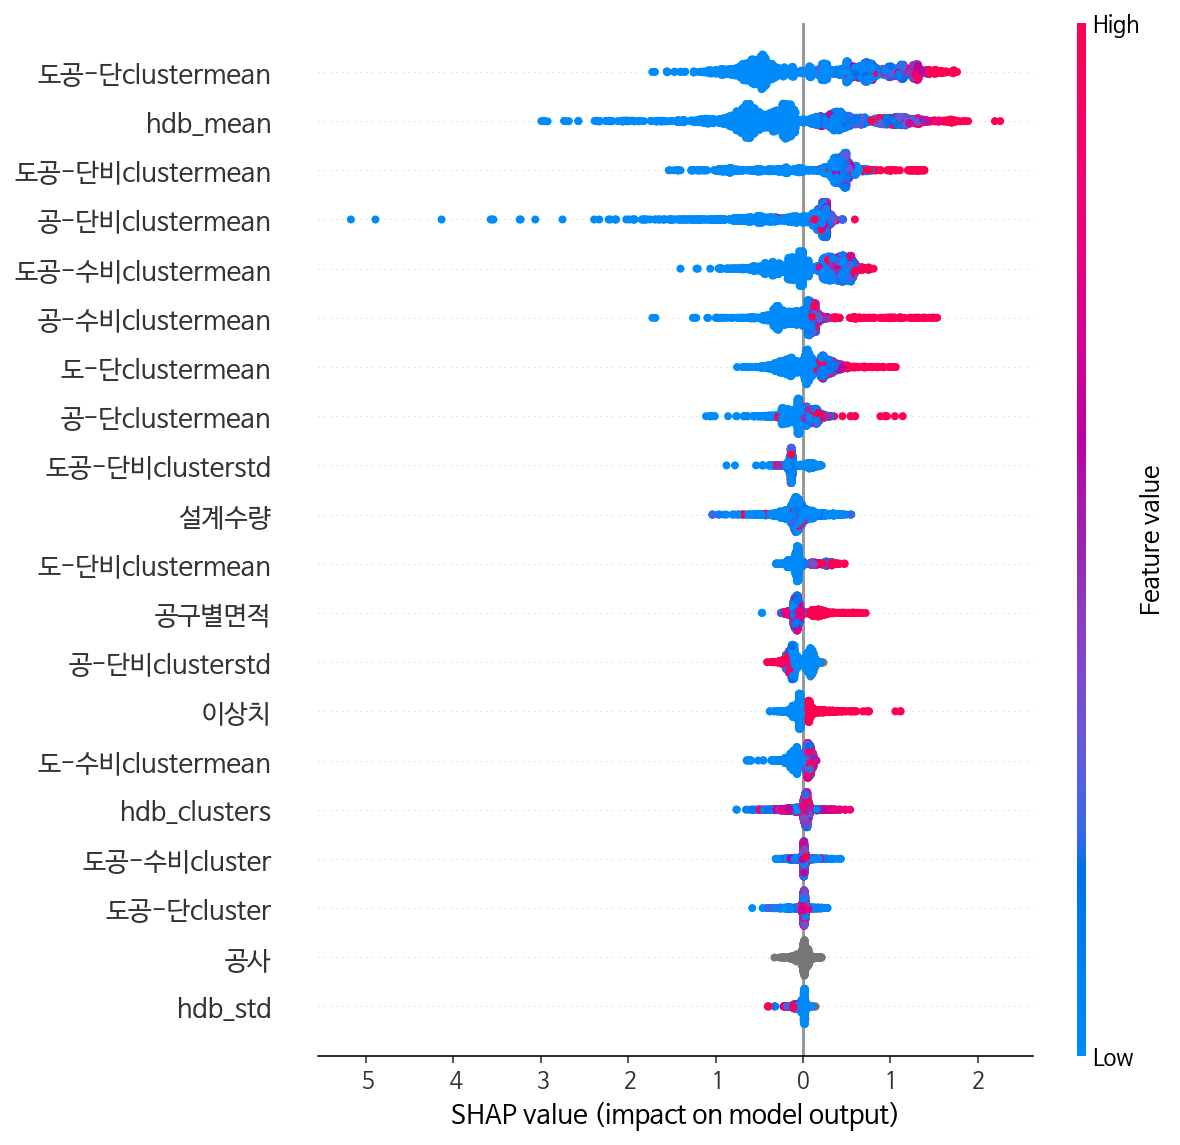

In [ ]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

## model save

In [ ]:
# from sklearn.externals import joblib

In [ ]:
# for i in range(len(models)):
#   joblib.dump(models[i],'/content/drive/My Drive/Colab Notebooks/data/빅청캠/lgb_%s.pkl'%(i))

In [ ]:
# X_test['pred']=np.expm1(pred)
# X_test['true']= y_test

In [ ]:
# X_test.groupby('공사')[['true','pred']].sum()

In [ ]:
# plt.pie(X_test.groupby('공사')[['true','pred']].sum()['pred'],
#         labels=X_test.groupby('공사')[['true','pred']].sum().index)
# plt.show()

In [ ]:
# plt.pie(X_test.groupby('공사')[['true','pred']].sum()['true'],
#         labels=X_test.groupby('공사')[['true','pred']].sum().index)
# plt.show()

In [ ]:
# df[df['도급단가합계']<0]